# Model development for multi-class of faults

In [1]:
import sys
import matplotlib.pyplot as plt
import matplotlib
import os
import pandas as pd
from lib import data_prep, feature_extraction, models
from sklearn.utils import shuffle
import numpy as np
import pickle
from sklearn import preprocessing

font = {
    "family": "sans-serif",
    "weight": "bold",
    "size": 16
}
matplotlib.rc("font", **font)

# Loading and testing the data
- Plotting to ensure validity
- Add more files to the training data as required

In [2]:
# Base directory
data_loc = os.path.join(os.getcwd(), "DATA")

# file name
file_names = {
    0: "machine_ON_no-ref_start-error_1.csv",  # Machine turned ON, and the parameter switch enable error
    1: "machine_ON_no-ref_start-error_2.csv",
    2: "machine_ON_no-ref_start-error_3.csv",
    3: "machine_ON_no-ref_start-error_4.csv",
    4: "machine_ON_ref_no-error_1.csv",  # Machine ON referenced and no-error idling
    5: "machine_ON_ref_no-error_2.csv",  # Machine ON referenced and no-error idling
    6: "machine_ON_ref_no-error_3.csv",
    7: "machine_ON_ref_no-error_4.csv",
    8: "machine_ON_ref_no-error_5.csv",
    9: "machine_ON_ref_no-error_6.csv",
    10: "machine_ON_ref_overtravel-error_x_neg_1.csv",  # Machine ON referenced and Overtravel for X negative
    11: "machine_ON_ref_overtravel-error_x_pos_1.csv",  # Machine ON referenced and Overtravel for X positive
    12: "machine_ON_no-ref_overtravel-error_x_neg_1.csv",  # Machine ON not-referenced and Overtravel for X negative
    13: "machine_ON_no-ref_overtravel-error_x_pos_1.csv", # Machine ON not-referenced and Overtravel for X positive
    14: "machine_ON_ref_overtravel-error_x_neg_axes-extreme_1.csv",
    15: "machine_ON_ref_overtravel-error_y_neg_axes-extreme_1.csv",  # Machine ON referenced and Overtravel for Y negative
    16: "machine_ON_ref_overtravel-error_y_neg_1.csv", # Machine and ON referenced and Overtravel in Y
    17: "machine_ON_ref_overtravel-error_y_pos_1.csv",  # Machine ON referenced and Overtravel for Y positive
    18: "machine_ON_ref_overtravel-error_z_neg_1.csv",  # Machine ON referenced and Overtravel for Z negative
    19: "machine_ON_ref_overtravel-error_z_pos_1.csv",  # Machine ON referenced and Overtravel for Z positive
}

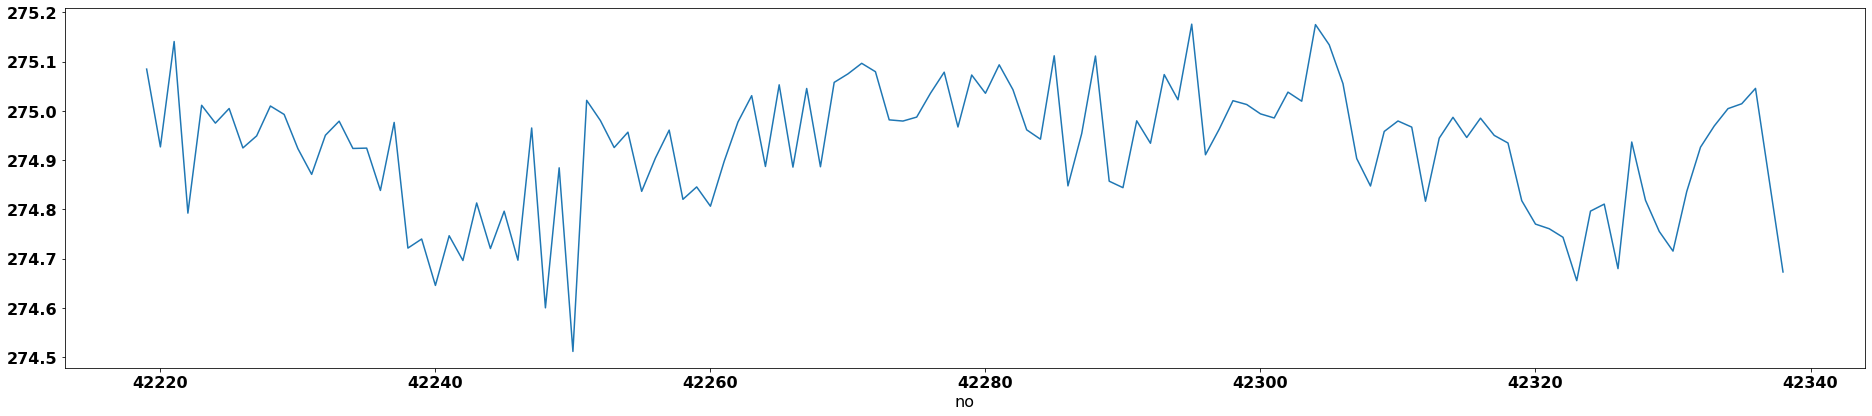

In [3]:
# load the data
index = 5
df = pd.read_csv(os.path.join(data_loc, file_names[index]), header="infer", index_col="no")
fig = plt.figure(figsize=(25, 5))
axs = fig.add_axes([0, 0, 1, 1])
df["PowerSum"][-120:].plot(ax=axs)

# Data preparation


## Segmentation

- Control different segmentation length
    - 2 mins
    - 1 min
    - 30 secs
    - 15 secs

- Refer to the spreadsheet in the results directory

In [4]:
segment_secs = 60

In [5]:
# Dont choose "no" and "sample_time" as they will be added later to the beginning
# Chosen - Three different power components for three phases
chosen_cols = ["Power1", "Power2", "Power3", "PowerReac1", "PowerReac2", "PowerReac3", "PowerApp1", "PowerApp2", "PowerApp3"]
segmented_data = {}
for index, file_name in file_names.items():
    path = os.path.join(data_loc, file_name)
    temp = data_prep.segment_data(file_name=path, col_names=chosen_cols, segment_secs=segment_secs)
    # Remove the sample_time col
    temp = temp[:, 1:, :]
    segmented_data[file_name] =  temp

In [6]:
# Print to ensure that segmentation is successful
for file_name in segmented_data.keys():

    sys.stdout.write(f"For the file-{file_name} the shape-{segmented_data[file_name].shape}\n")

For the file-machine_ON_no-ref_start-error_1.csv the shape-(60, 9, 19)
For the file-machine_ON_no-ref_start-error_2.csv the shape-(60, 9, 106)
For the file-machine_ON_no-ref_start-error_3.csv the shape-(60, 9, 859)
For the file-machine_ON_no-ref_start-error_4.csv the shape-(60, 9, 5054)
For the file-machine_ON_ref_no-error_1.csv the shape-(60, 9, 243)
For the file-machine_ON_ref_no-error_2.csv the shape-(60, 9, 705)
For the file-machine_ON_ref_no-error_3.csv the shape-(60, 9, 162)
For the file-machine_ON_ref_no-error_4.csv the shape-(60, 9, 1129)
For the file-machine_ON_ref_no-error_5.csv the shape-(60, 9, 88)
For the file-machine_ON_ref_no-error_6.csv the shape-(60, 9, 1436)
For the file-machine_ON_ref_overtravel-error_x_neg_1.csv the shape-(60, 9, 692)
For the file-machine_ON_ref_overtravel-error_x_pos_1.csv the shape-(60, 9, 295)
For the file-machine_ON_no-ref_overtravel-error_x_neg_1.csv the shape-(60, 9, 87)
For the file-machine_ON_no-ref_overtravel-error_x_pos_1.csv the shape-(60

## Determine classes

Make a choice on the number of classes to be used for study

In [9]:
# Associations between the classes and the files in this study
class_file_association = {
    "on-ref": ["machine_ON_ref_no-error_1.csv", "machine_ON_ref_no-error_2.csv", "machine_ON_ref_no-error_3.csv", "machine_ON_ref_no-error_4.csv", "machine_ON_ref_no-error_5.csv", "machine_ON_ref_no-error_6.csv"],

    "on-noref-error": ["machine_ON_no-ref_start-error_1.csv", "machine_ON_no-ref_start-error_2.csv", "machine_ON_no-ref_start-error_3.csv", "machine_ON_no-ref_start-error_4.csv"],

    "overtravel-x": ["machine_ON_ref_overtravel-error_x_neg_1.csv", "machine_ON_ref_overtravel-error_x_pos_1.csv", "machine_ON_no-ref_overtravel-error_x_neg_1.csv", "machine_ON_no-ref_overtravel-error_x_pos_1.csv", "machine_ON_ref_overtravel-error_x_neg_axes-extreme_1.csv"],

    "overtravel-y": ["machine_ON_ref_overtravel-error_y_neg_1.csv", "machine_ON_ref_overtravel-error_y_pos_1.csv",
                    "machine_ON_ref_overtravel-error_y_neg_axes-extreme_1.csv"],
    "overtravel-z": ["machine_ON_ref_overtravel-error_z_neg_1.csv", "machine_ON_ref_overtravel-error_z_pos_1.csv"],
}

In [10]:
# Okay
class_segmented_data = {}
for class_instance in class_file_association.keys():
    for index, file_name in enumerate(class_file_association[class_instance]):

        if index == 0:
            class_segmented_data[class_instance] = segmented_data[file_name]
        else:
            class_segmented_data[class_instance] = np.append(class_segmented_data[class_instance], segmented_data[file_name], axis=-1)

In [11]:
# Reshape the data appropriately
for class_instance in class_segmented_data.keys():
    class_segmented_data[class_instance] = np.transpose(class_segmented_data[class_instance], (2, 1, 0))

In [12]:
# Print to ensure that the files have been loaded correctly
for class_instance in class_segmented_data.keys():

    sys.stdout.write(f"The class-{class_instance} has the shape-{class_segmented_data[class_instance].shape}\n")

The class-on-ref has the shape-(3763, 9, 60)
The class-on-noref-error has the shape-(6038, 9, 60)
The class-overtravel-x has the shape-(1263, 9, 60)
The class-overtravel-y has the shape-(1397, 9, 60)
The class-overtravel-z has the shape-(1461, 9, 60)


## Feature Extraction

- Time domain
- Frequency domain
- Time-frequency domain

In [13]:
# Features to extract
features_to_select = input("Features to select\n\t--All features 'all'\n\t--Time domain features => 'time'\n\t--Frequency domain features => 'freq'\n\t--Time-Frequency domain features => 'time-freq'\n--Choice: ")

In [14]:
class_dataset_features = {}
for class_instance in class_segmented_data.keys():
    dataset_features = []
    for row in class_segmented_data[class_instance]:
        computed_features = []
        for col in row:
            freq_args = [{"axis": 0}, {"axis": 0}, {"axis": 0, "nperseg": 30}]
            freq_time_args = [{"wavelet": "db1"}, {"wavelet": "db1"}, {"wavelet": "db1"}]
            if features_to_select == 'all':
                computed_features += feature_extraction.compute_all_features(col, freq_args=freq_args, freq_time_args=freq_time_args)
            elif features_to_select == 'time':
                computed_features += feature_extraction.compute_time_domain_features(col)
            elif features_to_select == 'freq':
                computed_features += feature_extraction.compute_frequency_domain_features(col, args=freq_args)
            elif features_to_select == "time-freq":
                computed_features += feature_extraction.compute_time_frequency_features(col, args=freq_time_args)
            else:
                sys.exit("Unknown Choice on the feature selection")

        # Append to a list
        dataset_features.append(computed_features)

    # Add to class instance
    class_dataset_features[class_instance] = np.array(dataset_features)

In [15]:
sys.stdout.write("After feature extraction process\n\n")
for class_instance in class_dataset_features.keys():

    sys.stdout.write(f'For the class-{class_instance} , the extracted features has the shape={class_dataset_features[class_instance].shape}\n')

After feature extraction process

For the class-on-ref , the extracted features has the shape=(3763, 153)
For the class-on-noref-error , the extracted features has the shape=(6038, 153)
For the class-overtravel-x , the extracted features has the shape=(1263, 153)
For the class-overtravel-y , the extracted features has the shape=(1397, 153)
For the class-overtravel-z , the extracted features has the shape=(1461, 153)


## Generate training data

- Combine all with appropriate labels
- Using KFold

In [16]:
class_label_associations = {
    "on-ref": 0,
    "on-noref-error": 1,
    "overtravel-x": 2,
    "overtravel-y": 3,
    "overtravel-z": 4
}
for index, class_instance in enumerate(class_dataset_features.keys()):

    temp_X = class_dataset_features[class_instance]
    temp_y = np.repeat(class_label_associations[class_instance], temp_X.shape[0])[:, np.newaxis]

    if index == 0:
        X = temp_X
        y = temp_y
    else:
        X = np.append(X, temp_X, axis=0)
        y = np.append(y, temp_y, axis=0)

# Shuffle the dataset
X, y = shuffle(X, y, random_state=42)
# To a vector format
y =  np.squeeze(y)

sys.stdout.write(f"The final combined shape-{X.shape}\n")

The final combined shape-(13922, 153)


# Model development
- Choose among the available models
- Set the parameters appropriately
- Train the model and get the metrics

## Hyper-parameters optimization

- trying to find the best hyperparameters for each of the models

In [ ]:
# Manually chosen ones
model_params = {
    "LogisticRegression" : {"class_weight": "balanced", "max_iter": 5000, "multi_class": "multinomial", "n_jobs": 4},
    "DecisionTreeClassifier": {"min_samples_split": 100, "class_weight": "balanced"},
    "KNeighborsClassifier": {"n_neighbors": 10},
    "SVC": {"kernel": "rbf", "tol":1e-7, "class_weight": "balanced"},
    "BaggingClassifier": {"n_estimators": 50},
    "RandomForestClassifier": {"n_estimators": 100, "min_samples_split": 100, "class_weight": "balanced"},
}

In [ ]:
# Possible parameters
hyper_params = {
    "LogisticRegression" : {"tol": [0.0001, 0.00005, 0.0000005], "max_iter": [5000, 10000, 20000], "multi_class": ["multinomial"], "n_jobs": [4], "class_weight": ["balanced"]},
    "DecisionTreeClassifier": {"min_samples_split": [100, 500], "max_depth": [None, 5, 10, 15, 50], "min_samples_leaf":[1, 100, 500], "class_weight": ["balanced"]},
    "KNeighborsClassifier": {"n_neighbors": [10, 5, 20, 50, 100], "weights":["uniform", "distance"]},
    "SVC": {"kernel": ["linear", "poly", "rbf"], "tol":[1e-7, 1e-3], "class_weight": ["balanced"]},
    "BaggingClassifier": {"n_estimators": [10, 20, 50, 100]},
    "RandomForestClassifier": {"n_estimators": [100, 50, 200], "min_samples_split": [100, 500], "max_depth": [None, 5, 10, 15, 50], "min_samples_leaf":[1, 100, 500], "class_weight": ["balanced"]},
}

In [ ]:
# Create repo of models for hyperparameter optimization
models_repo_hyperopt = models.Models()
# Initialize the models
models_repo_hyperopt.create_models(model_params)

# Optimize the hyper-parameters for all models
models_repo_hyperopt.optimize_hyperparameters(hyperparameters=hyper_params, X_train=X, y_train=y, standardize=True)

# Print the optimized f1-scores
print("F1-Scores")
for model_name in models_repo_hyperopt.hyper_opt_model_scores.keys():

    print(f"{model_name} - {models_repo_hyperopt.hyper_opt_model_scores[model_name]}")

In [ ]:
# Get the best performing parameters
for model_name in models_repo_hyperopt.hyper_opt_model_params.keys():
    print(f"Model name: {model_name}")
    print(models_repo_hyperopt.hyper_opt_model_params[model_name])
    print()


## CV Fold training

- Training across 10-fold CV

In [17]:
# Set this if you are optimizing before this step
# model_params = models_repo_hyperopt.hyper_opt_model_params

# The ones below are hardcoded optimized hyperparameters
# for each of the models
model_params = {'LogisticRegression': {'max_iter': 5000, 'multi_class': 'multinomial', 'n_jobs': 4, 'tol': 0.0001, "class_weight": "balanced"},
 'DecisionTreeClassifier': {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 100},
 'KNeighborsClassifier': {'n_neighbors': 20},
 'SVC': {'class_weight': 'balanced', 'kernel': 'linear', 'tol': 1e-07},
 'BaggingClassifier': {'n_estimators': 50},
 'RandomForestClassifier': {'class_weight': 'balanced', 'max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 100, 'n_estimators': 200}}

In [18]:
# Create repo of models
models_repo = models.Models()
# Initialize the models
models_repo.create_models(model_params)

# 10-fold to determine the effective performance of all models
# And standardize the data
cv_results_summary = models_repo.train_models_cvfolds(X, y, summarize_results=True, standardize=True)

In [21]:
# Print the required dataframe and record the metrics
cv_results_summary["SVC"]

,average,std,min,max,count
accuracy_score,0.971196,0.004183,0.963362,0.974856,10
balanced_accuracy_score,0.941172,0.008374,0.921422,0.951905,10
f1_score,0.971196,0.004183,0.963362,0.974856,10
recall_score,0.971196,0.004183,0.963362,0.974856,10
precision_score,0.971196,0.004183,0.963362,0.974856,10


# Save the data

Just for future reference - can be used later to analyze the results

In [ ]:
train_save_dir = os.path.join(os.getcwd(), "results")
train_save_file_name = "training_data.pkl"

# Training data
train_data = {
    "X": X,
    "y": y
}

with open(os.path.join(train_save_dir, train_save_file_name), "wb") as file_handle:
    pickle.dump(train_data, file_handle, protocol=pickle.HIGHEST_PROTOCOL)